# Exercise: Field of View

---

Prof. Dr.-Ing. Antje Muntzinger, Hochschule für Technik Stuttgart

antje.muntzinger@hft-stuttgart.de

---

In this exercise, we check if an object is inside or outside the field of view of our camera. This is important for e.g. tracking pedestrians in self-driving cars: If the pedestrian is inside the field of view, it should be seen by the camera, so if the camera image shows no pedestrian, maybe it is a false alarm and we should not brake. But if the pedestrian is outside the field of view, we should be very careful because he or she might still be there, so we need some blind spot tracking. 


<img src="../images/fov.png" width="800">

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

**TODO:** Implement the `in_fov` function below. Return True if the object `x` (e.g., the pedestrian) is located inside sensor's field of view, otherwise return False. 

**HINT:** Don't forget to transform from vehicle to sensor coordinates. Here we have a camera that looks 45 degrees to the left and is placed 4 meters in front of the vehicle origin:

<img src="../images/fov2.png" width="500">

The homogeneous transformation matrix from world to camera coordinates is given by:

<img src="../images/fov3.png" width="600">


**HINT 2:** You need to calculate the angle $\alpha$ between the object position and the i-axis using trigonometric formulas, then compare $\alpha$ with $\varphi$!

In [5]:
class Camera:
    '''Camera sensor class including field of view and coordinate transformation'''
    def __init__(self, phi, t):
        '''Constructor of the Camera class
        Input: phi - rotation angle around z-axis (yaw angle) in radians
                t - translation vector in vehicle coordinates
        '''
        self.fov = [-np.pi/4, np.pi/4] # sensor field of view / opening angle (here: 90 degrees)
        
        # compute rotation around z axis
        M_rot = np.array([[np.cos(phi), -np.sin(phi), 0],
                    [np.sin(phi), np.cos(phi), 0],
                    [0, 0, 1]])
        
        # coordiante transformation matrix from sensor to vehicle coordinates
        self.sens_to_veh = np.identity(4)            
        self.sens_to_veh[0:3, 0:3] = M_rot
        self.sens_to_veh[0:3, 3] = t[:,0]
        self.veh_to_sens = np.linalg.inv(self.sens_to_veh) # transformation vehicle to sensor coordinates
    
    def in_fov(self, x):
        '''
        Check if an object x is in the field of view of the camera
        Input: x - object position in vehicle coordinates
        '''
        # Wenn mehr als 3 Zeilen: nur Position extrahieren
        if x.shape[0] > 3:
            x = x[0:3]
        # Homogenisiere die Eingabe (3D -> 4D)
        x_hom = np.vstack((x, np.array([[1]])))  # shape: (4, 1)

        # Transformiere den Punkt in Sensor-Koordinaten
        x_sens = self.veh_to_sens @ x_hom  # shape: (4, 1)
    # Extrahiere i_s und j_s Komponenten (x und y in Sensor-Koordinaten)
        x_i = x_sens[0,0]
        x_j = x_sens[1,0]
    # Überprüfe, ob das Objekt vor der Kamera liegt (x_i > 0)
        if x_i <= 0:
            return False

# Berechne den Winkel alpha zum i_s-Achse (horizontale Richtung der Kamera)
        alpha = np.arctan(x_j/x_i)

        # Prüfe, ob alpha innerhalb des Sichtfeldes liegt
        visible = (self.fov[0] <= alpha) and (alpha <= self.fov[1])
        return visible

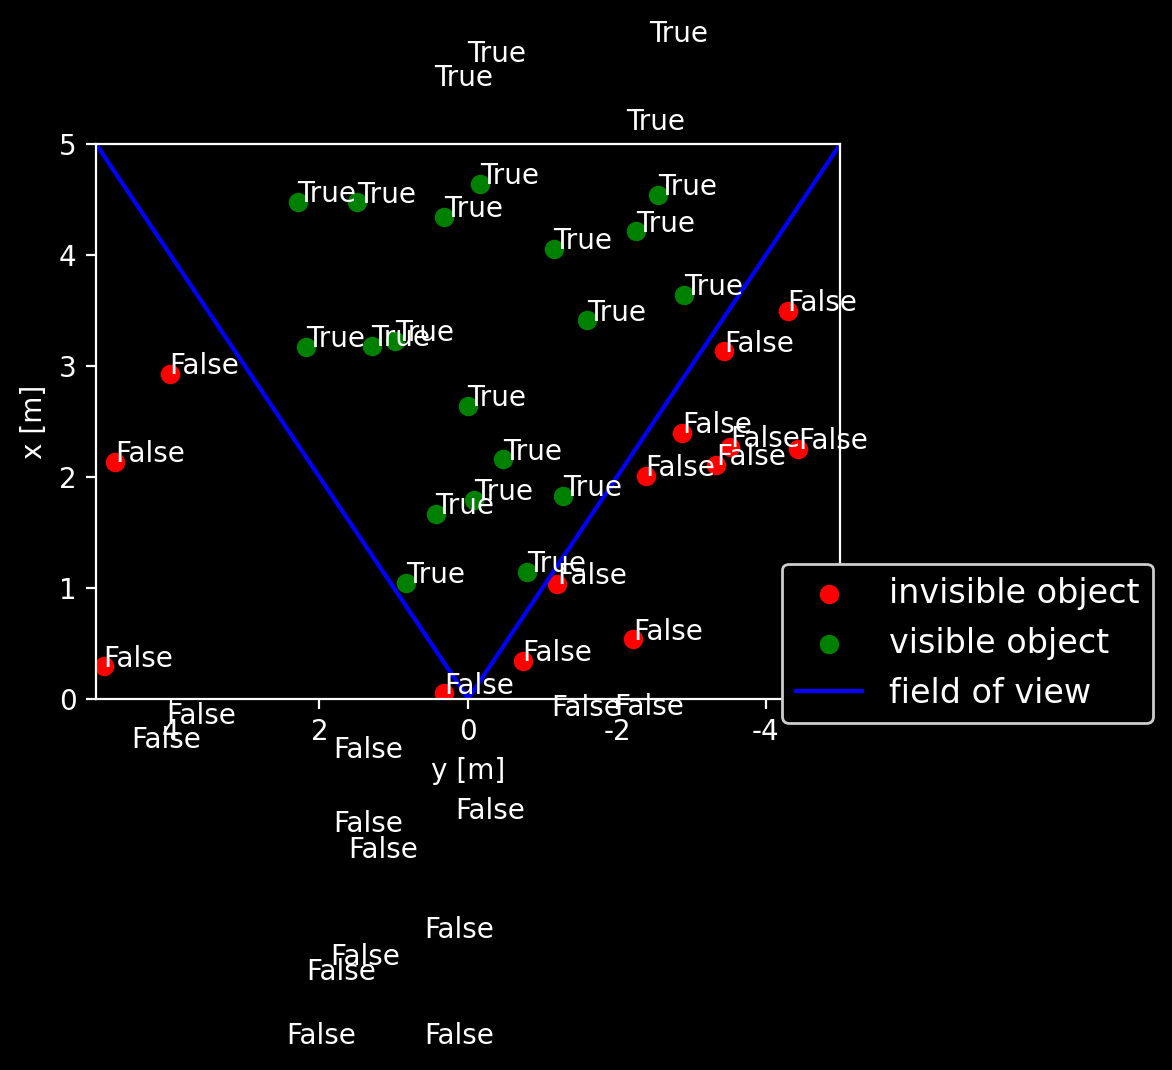

In [6]:
# camera with translation and rotation angle (here: 45 degrees)
t = np.array([[4],
                [0],
                [0]])
phi = np.radians(45)
cam = Camera(phi, t)

# initialize visualization
fig, ax = plt.subplots()

for i in range(50):
    # define random object position (e.g., pedestrian)
    # x = [x, y, z, vx, vy, vz] - we don't use the velocities here
    x = np.array([[np.random.uniform(0,10)],
                [np.random.uniform(-2,5)],
                [0],
                [0],
                [0],
                [0]])

    # check if x is visible by camera
    result = cam.in_fov(x)
    
    # plot results
    pos_veh = np.ones((4, 1)) # homogeneous coordinates
    pos_veh[0:3] = x[0:3] 
    pos_sens = cam.veh_to_sens @ pos_veh # transform from vehicle to sensor coordinates
    if result == True:
        col = 'green'
        ax.scatter(-pos_sens[1,0], pos_sens[0,0], marker='o', color=col, label='visible object')
    else:
        col = 'red'
        ax.scatter(-pos_sens[1,0], pos_sens[0,0], marker='o', color=col, label='invisible object')
    ax.text(-pos_sens[1,0], pos_sens[0,0], str(result))
    
# plot FOV    
ax.plot([0, -5], [0, 5], color='blue', label='field of view') 
ax.plot([0, 5], [0, 5], color='blue')

# remove repeated labels
handles, labels = ax.get_legend_handles_labels()
handle_list, label_list = [], []
for handle, label in zip(handles, labels):
    if label not in label_list:
        handle_list.append(handle)
        label_list.append(label)
ax.legend(handle_list, label_list, loc='center left', shadow=True, fontsize='large', bbox_to_anchor=(0.9, 0.1))

# axis
ax.set_xlabel('y [m]')
ax.set_ylabel('x [m]')
ax.set_xlim(-5,5)
ax.set_ylim(0,5)

# correct x ticks (positive to the left)
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(-x) if x!=0 else '{0:g}'.format(x))
ax.xaxis.set_major_formatter(ticks_x)

plt.show() 